### (TSP) Traveling Salesman Problem
- Find the shortest route through $n$ nodes such that 
    - the route begins and ends at the same location 
    - the route visits every node
- Sets:
    - $N=\{1,...,n\}$: set of nodes
- Parameters:
    - $c_{ij}$: distance (or transportation cost) from node $i$ to node $j$
- Decision variables:
    - $x_j=\begin{cases}1, \quad\text{if the tour goes from }i\text{ to }j\\0, \quad\text{O.W.}\end{cases}$

<br>

$$
\begin{split}
\text{(TSP)}\quad & \text{minimize}\quad \sum\limits_{i,j\in N}c_{ij}x_{ij}\\
&\begin{split}
\text{subject to}\quad\quad \sum\limits_{i\in N}&x_{ih}+\sum\limits_{j\in N}x_{hj}=2 \quad\quad &\forall h\in N\\
   \sum\limits_{i,j\in S}&x_{ij}\le |S|-1 &\forall S\subseteq N: 2\le |S|\le n-1\\
        &x_{ij}\in \{0,1\}     &\forall i,j\in N\\ 
\end{split}
\end{split}
$$

In [1]:
# import libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from gurobipy import Model, GRB, quicksum
%matplotlib inline

In [2]:
# settings
sns.reset_orig
sns.set_style('darkgrid')
sns.set_palette('Set1')

np.set_printoptions(linewidth=200)

In [3]:
# import data
i_data = pd.read_excel('data.xlsx', sheet_name='i_data')
dist_ij = pd.read_excel('data.xlsx', sheet_name='dist_ij').values

In [4]:
# declare the parameters and sets
N = np.arange(len(i_data['X'].values))

I = [i for i in range(len(N))]
J = I
H = I
A = [(i, j) for i in I for j in J]

S = []
for n in range(2, len(N)):
    S += itertools.combinations(N, int(n))

cost = 2
c = {(i, j): dist_ij[i, j]*2 for (i, j) in A}

In [5]:
# create model
mdl = Model('TSP')

Academic license - for non-commercial use only - expires 2022-08-28
Using license file C:\Users\jack4\gurobi.lic


In [6]:
# add model variables
x = mdl.addVars(A, vtype=GRB.BINARY)

In [7]:
# add objective function
mdl.ModelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(c[i,j]*x[i,j] for i,j in A))

In [8]:
%%time

# add the model constraints
mdl.addConstrs(
    quicksum(x[i,h] for i in I) + 
    quicksum(x[h,j] for j in J) == 2 
    for h in H
)
mdl.addConstrs(
    quicksum(
        x[i,j] for i,j in itertools.combinations(s, 2)
    ) 
    <= len(s) - 1
    for s in S
)
mdl.addConstrs(x[i,j] + x[j,i] <= 1 for i,j in A)
mdl.update()

Wall time: 938 ms


In [9]:
%%time

# optimize
mdl.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 32991 rows, 225 columns and 860925 nonzeros
Model fingerprint: 0xd1e5b71a
Variable types: 0 continuous, 225 integer (225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 3401.5448787
Presolve removed 32976 rows and 120 columns
Presolve time: 0.26s
Presolved: 15 rows, 105 columns, 210 nonzeros
Found heuristic solution: objective 1354.2515191
Variable types: 0 continuous, 105 integer (105 binary)

Root relaxation: objective 1.343404e+03, 23 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0      1354.25152 1354.25152  0.00%     -  

In [10]:
# get the route
routes = [(i,j) for i,j in A if x[i,j].X > 0]
routes

[(4, 0),
 (6, 4),
 (7, 3),
 (8, 2),
 (9, 1),
 (9, 5),
 (10, 5),
 (10, 7),
 (11, 1),
 (12, 0),
 (12, 2),
 (13, 3),
 (13, 8),
 (14, 6),
 (14, 11)]

Text(0.5, 1.0, 'Route')

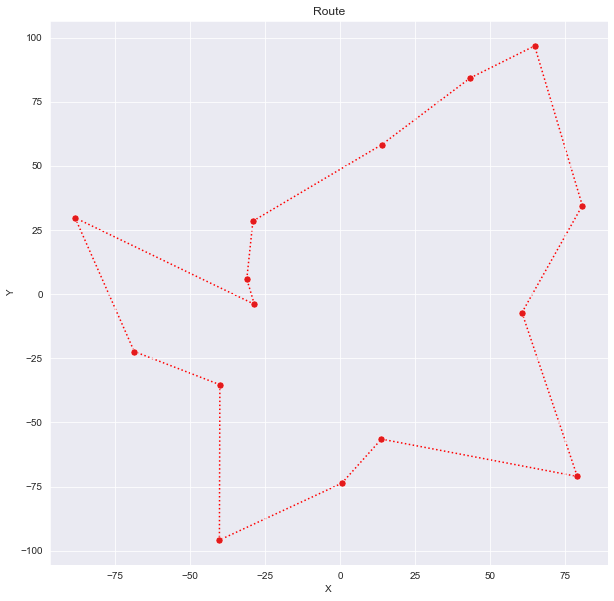

In [11]:
# plot the coverage
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='X', y='Y', data=i_data, s=50, legend=False, label="Location")

for path in routes:
    point1 = [i_data['X'][path[0]], i_data['Y'][path[0]]]
    point2 = [i_data['X'][path[1]], i_data['Y'][path[1]]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    
    plt.plot(x_values, y_values, 'r', linestyle=":", zorder=0)

plt.title('Route')

In [12]:
# find objective value
print('Objective value =', sum(c[a]*x[a].X for a in A))

Objective value = 1354.2515190862532
